In [31]:
from bunkadata import bunka_twitter, bunka_reddit
from bunkatech.nested_topic_modeling import nested_topic_modeling
import plotly
import os
import bamboolib

#### Extract Data from different sources

In [33]:
df_twitter = bunka_twitter(
    search_query="ukraine",
    limit=3000,
    output_path="data_scraped",
    save_to_graph=True,
    date_min = "2022-02-23",
    date_max = "2022-02-24",
)

Searching for "ukraine lang:en until:2022-02-24 since:2022-02-23"
Serializing data into a Knowledge Graph: 100%|███████████████████████| 19824/19824 [01:00<00:00, 329.27it/s]
2022-02-24 21:38:54,650  - BUNKA -  : Process over!
2022-02-24 21:38:54,650 - INFO : Process over!


In [44]:
df_twitter = df_twitter[df_twitter['text'] != 'nan'].reset_index(drop=True)
df_twitter['source'] = 'twitter'

In [4]:
df_reddit = bunka_reddit(
    sorting_strategy="search",
    query="ukraine",
    limit=100,
    sort="hot",
    path="data_scraped",
    subreddit_name="citypop",
    save_images=False,
    save_to_graph=True,
    client_id=os.getenv("REDDIT_CLIENT_ID"),
    client_secret=os.getenv("REDDIT_CLIENT_SECRET"),
    user_agent=os.getenv("REDDIT_USER_AGENT"),
)
df_reddit['source'] = 'reddit'

Serializing data into a Knowledge Graph: 100%|██████████████████████| 11638/11638 [00:09<00:00, 1253.33it/s]
2022-02-24 21:22:55,714 - INFO : Data Serialized into a Knowledge Graph!
2022-02-24 21:22:56,630 - INFO : Process over!


#### Merge the Datasets

In [50]:
import pandas as pd
data = pd.concat([df_twitter.sample(2000), df_reddit.sample(2000)]).reset_index(drop=True)

#### Compute the maps

In [51]:
model = nested_topic_modeling()
bunka = model.fit(
    data,
    text_var="text",
    index_var="id",
    sample_size=4000,
    sample_terms=2000,
    embeddings_model="sbert",
    ngrams=(1, 2),
    ents=False,
    language="en",
    db_path=".",
)

plotly.offline.plot(bunka.treemap, auto_open=True, filename="treemap.html")

2022-02-24 21:41:52,273 - INFO : Load pretrained SentenceTransformer: distiluse-base-multilingual-cased-v1


Embeddings..


2022-02-24 21:42:02,653 - INFO : Use pytorch device: cpu


Territory embedding..


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Reducing the vectors..
UMAP(angular_rp_forest=True, metric='cosine', n_components=5, n_neighbors=10, verbose=True)
Thu Feb 24 21:46:16 2022 Construct fuzzy simplicial set
Thu Feb 24 21:46:30 2022 Finding Nearest Neighbors
Thu Feb 24 21:46:30 2022 Finished Nearest Neighbor Search
Thu Feb 24 21:46:30 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Feb 24 21:46:35 2022 Finished embedding
Extract Terms...


100%|███████████████████████████████████████████████████████████████████| 2000/2000 [00:20<00:00, 96.91it/s]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'treemap.html'

In [133]:
plotly.offline.plot(bunka.sunburst, auto_open=True, filename="sunburst.html")
plotly.offline.plot(bunka.sankey, auto_open=True, filename="sankey.html")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'sankey.html'

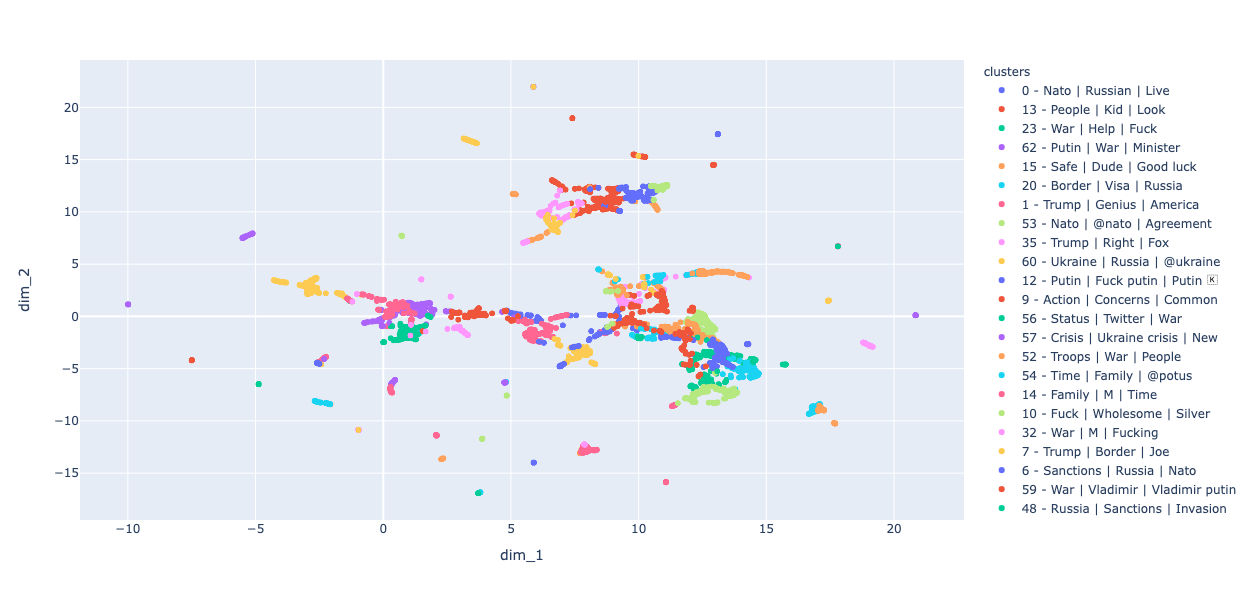

In [100]:
fig = model.visualize_embeddings(nested_level = 2 , width = 1000, height = 600)
fig.show()

In [105]:
df_centroid = model.get_centroid_documents(nested_level = 2, top_elements = 4)

df_centroid[df_centroid['clusters']==3]['centroid_docs'].values

array(["No russian who matters will have any amount of money that matters on any network America can touch. Anyone selling you on sanctions as relevant here is either clueless or a liar. #Biden #Putin #Russia #NATO #Ukraine #Donbass || The Ruble has been hammered today. At one point it was down almost 10%. I can't say it's gonna get easier going forward the longer this drags on. Not that the Russian elites care since they probably have all their assets in foreign currency. Once again, the Russian people are victims of a government who doesn't care one iota about them. || What I actually see is that the sanctionst for Russia are not so hard how we think. The hardest thing was that Germany stopps the Nord-stream 2 gas pipeline. But Russia can work without the pipeline so I think these sanctions were useless. #Russia #EU #Ukraine || #US imposing major sanctions on Russian banking.  All Russian assets in America are now frozen."],
      dtype=object)

#### Get the Wikidata subclass

In [55]:
from bunkadata.graphdb.extract_entity import get_wikidata_id
from bunkadata.scraping.wikidata.wikidata import get_instance_func

In [58]:
terms = bunka.terms.copy()[:100]
terms['text'] = terms['text'].apply(lambda x: x.split(' | '))
terms = terms.explode('text')
terms['text'] = terms['text'].apply(lambda x: x.lower().title())
terms = terms[['lemma', 'text']].drop_duplicates()

In [59]:
from tqdm import tqdm
tqdm.pandas()

In [60]:
# Get the wikidata_ids of terms (takes the longest time)
terms['wikidata_id'] = terms['text'].progress_apply(lambda x : get_wikidata_id(x))

100%|█████████████████████████████████████████████████████████████████████| 160/160 [00:45<00:00,  3.54it/s]


In [61]:
# Get the instance of the wikidata_ids
terms['instance'] = terms['wikidata_id'].progress_apply(lambda x: get_instance_func(x))

100%|█████████████████████████████████████████████████████████████████████| 160/160 [00:43<00:00,  3.71it/s]


In [74]:
import numpy as np

In [131]:
mask = (terms['wikidata_id'] is not None) & (terms['instance'] != 'Wikimedia disambiguation page')  & (terms['instance'] != None)
final_terms = terms[mask].reset_index(drop=True)

In [132]:
final_terms

,lemma,text,wikidata_id,instance
0,ukraine,Ukraine,Q212,sovereign state
1,russia,Russia,Q159,sovereign state
2,russia,Russias,Q4463021,people
3,putin,Putin,Q7747,human
4,putin,Putins,None,None
...,...,...,...,...
94,question,Question,Q189756,None
95,question,Questions,Q189756,None
96,hell,Hell,Q564,religious concept
97,wrong,Wrong,Q6765918,None
